## 🌐 Feature Engineering



En este ipynb vamos a realizar Feature Engineering, creando dataframes especificos para ser consultados por la api, desarrollando las funciones para los endpoint 


 📥Importaciones 

In [1]:
import os  # OS proporciona funciones para interactuar con el sistema operativo 
import pyarrow as pa  # PyArrow se utiliza para trabajar con formatos de datos columnares y eficientes como Parquet
import pyarrow.parquet as pq  # Importamos Parquet

# Importación del módulo warnings para controlar advertencias

import warnings
# Importación de pandas y se asigna el alias 'pd' para su uso

import pandas as pd
from data_utils import analisis_sentimiento, ej_review_sentimiento, data_type_check_EDA
# Configuración de la omisión de advertencias
warnings.filterwarnings("ignore")
# Carga de la extensión autoreload y configuración para recargar automáticamente módulos
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

___


## 📊 Análisis de Sentimientos

___




**'sentiment_analysis'** reemplaza a **'reviews_review'** : se crea esta nueva columna para realizar un análisis de sentimientos en los comentarios de los usuarios.

📦 Extracción de los conjuntos de datos
* ✍️ **Extraemos df_user_reviews:** usuarios que realizaron reseñas de los juegos que consumen.


In [2]:
df_user_reviews = pd.read_parquet('../0 Dataset/1.3_user_review_LISTO.parquet')

**Utilizamos la biblioteca TextBlob** , que es una herramienta de procesamiento de lenguaje natural (NLP) en Python en esta columna y aplico un análisis de sentimiento básico.

La escala utilizada es la siguiente:

* 👎 **0** si el sentimiento es **malo.**
* 😐 **1** si el sentimiento es **neutral o no hay revisión.**
* 👍 **2** si el sentimiento es **positivo.**

Esta metodología asigna un valor numérico a cada texto, en este caso, a los comentarios de los usuarios en relación con un juego específico, para representar si el sentimiento expresado en el texto es negativo, neutral o positivo.

El análisis se basa en la polaridad calculada por TextBlob, donde se considera que las polaridades negativas están por debajo de -0.2, las positivas por encima de 0.2 y las neutrales entre estos valores.


In [3]:
df_user_reviews['sentiment_analysis'] = df_user_reviews['reviews_review'].apply(analisis_sentimiento)
df_user_reviews.head()

,user_id,user_url,reviews_posted,reviews_item_id,reviews_helpful,reviews_recommend,reviews_review,sentiment_analysis
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"Posted November 5, 2011.",1250,No ratings yet,True,Simple yet with great replayability. In my opi...,1
1,js41637,http://steamcommunity.com/id/js41637,"Posted June 24, 2014.",251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,1
2,evcentric,http://steamcommunity.com/id/evcentric,Posted February 3.,248820,No ratings yet,True,A suitably punishing roguelike platformer. Wi...,2
3,doctr,http://steamcommunity.com/id/doctr,"Posted October 14, 2013.",250320,2 of 2 people (100%) found this review helpful,True,This game... is so fun. The fight sequences ha...,2
4,maplemage,http://steamcommunity.com/id/maplemage,"Posted April 15, 2014.",211420,35 of 43 people (81%) found this review helpful,True,Git gud,1


In [4]:
#Reviso algunos ejemplos para cada una de las clases de sentimiento.
ej_review_sentimiento(df_user_reviews['reviews_review'], df_user_reviews['sentiment_analysis'])

En la sección de evaluación de sentimientos, se presentan los siguientes ejemplos de reseñas para 0:
Reseña: 1: This game is Marvellous.
Reseña: 2: Killed the Emperor, nobody cared and got away with it. Accidentally killed a chicken and everybody decided to gang up on me. 10/10
Reseña: 3: This Game Doesn't Work


En la sección de evaluación de sentimientos, se presentan los siguientes ejemplos de reseñas para 1:
Reseña: 1: Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.
Reseña: 2: I know what you think when you see this title "Barbie Dreamhouse Party" but do not be intimidated by it's title, this is easily one of my GOTYs. You don't get any of that cliche game mechanics that all the latest games have, this is simply good core gameplay. Yes, you can't 360 noscope your friends, but what yo

🗑️ Al final del proceso, la columna 'reviews_review' se elimina del conjunto de datos. 



 Resumen del DataFrame 'df_user_reviews': 

Dimensiones:  (57397, 6)
              columna  no_nulos  %_no_nulos  nulos  %_nulos tipo_dato
0             user_id     57397       100.0      0      0.0    object
1            user_url     57397       100.0      0      0.0    object
2      reviews_posted     57397       100.0      0      0.0    object
3     reviews_item_id     57397       100.0      0      0.0     int64
4   reviews_recommend     57397       100.0      0      0.0      bool
5  sentiment_analysis     57397       100.0      0      0.0     int64


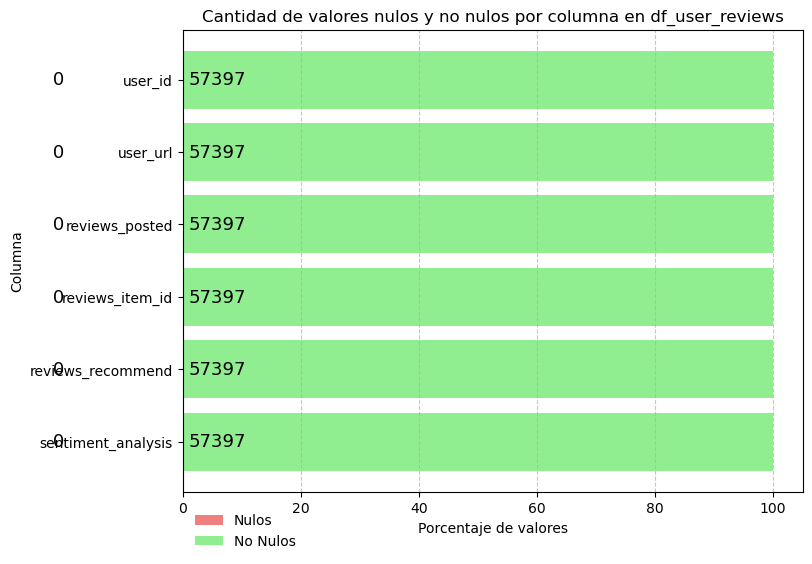

In [5]:
df_user_reviews = df_user_reviews.drop(columns=['reviews_review','reviews_helpful'])
data_type_check_EDA(df_user_reviews)

 **📤 LOAD** (Guardamos los cambios y borramos el parquet viejo y dejamos el nuevo que tiene el analisis de sentimiento)


In [6]:
limpio = '../0 Dataset/1.3_user_review_sentiment.parquet'
df_user_reviews.to_parquet(limpio, index=False)
print(f'Se guardó el archivo {limpio}')

Se guardó el archivo ../0 Dataset/1.3_user_review_sentiment.parquet


___



## 1 🌐 `developer(desarrollador: str)`: 

___


 Devuelve la cantidad de juegos y porcentaje de contenido Free por año según empresa desarrolladora

🌐Para acelerar la velocidad de la api, he decidido crear un DF especifico, usando developer, id, release_year y price.

In [7]:
#Cargamos los datos de Steam Games
df_steam_games = pd.read_parquet('../0 Dataset/1.1_steam_games_LISTO.parquet')

In [8]:
#Agrupamos el dataframe por columnas, calculamos la cantidad de items y el % gratuito para cada combinacion de desarrollador y año.
developer_stats = df_steam_games.groupby(['developer', 'release_year']).agg(
    cantidad_items=('id', 'count'),
    contenido_free=('price', lambda x: (x == 0).mean())
)
#Reseteamos el indice para facilitar el acceso a los datos
developer_stats = developer_stats.reset_index()


In [9]:
#Renombramos las columnas par que coincidan con los nombres esperados en el endpoint
developer_stats = developer_stats.rename(columns={
    'developer': 'Desarrollador',
    'release_year': 'Año',
    'cantidad_items': 'Cantidad de Items',
    'contenido_free': 'Contenido Free'
})

In [10]:
#Creamos nuestra funcion
def developer(desarrollador: str):
    result = developer_stats[developer_stats['Desarrollador'] == desarrollador]
    return result.to_dict(orient='records')

In [11]:
#Probamos la funcion
resultado = developer('Capcom')
print(resultado)

[{'Desarrollador': 'Capcom', 'Año': 2008, 'Cantidad de Items': 2, 'Contenido Free': 0.0}, {'Desarrollador': 'Capcom', 'Año': 2009, 'Cantidad de Items': 3, 'Contenido Free': 0.0}, {'Desarrollador': 'Capcom', 'Año': 2011, 'Cantidad de Items': 8, 'Contenido Free': 0.0}, {'Desarrollador': 'Capcom', 'Año': 2013, 'Cantidad de Items': 14, 'Contenido Free': 0.0}, {'Desarrollador': 'Capcom', 'Año': 2014, 'Cantidad de Items': 21, 'Contenido Free': 0.0}, {'Desarrollador': 'Capcom', 'Año': 2015, 'Cantidad de Items': 33, 'Contenido Free': 0.0}, {'Desarrollador': 'Capcom', 'Año': 2016, 'Cantidad de Items': 9, 'Contenido Free': 0.1111111111111111}, {'Desarrollador': 'Capcom', 'Año': 2017, 'Cantidad de Items': 40, 'Contenido Free': 0.025}]


Exito. Guardamos nuestro df

In [12]:
#Guardamos nuestro df developer_stats para la api en formato parquet

table = pa.Table.from_pandas(developer_stats)
ruta_parquet = os.path.join('..', '0 Dataset', '2.2.1_API_developer.parquet')
developer_stats.to_parquet(ruta_parquet)
print(f'Se guardó el archivo {ruta_parquet}')

Se guardó el archivo ..\0 Dataset\2.2.1_API_developer.parquet


___

## 2 🌐 `userdata(User_id: str)` :  

___



Debe devolver cantidad de dinero gastado por el usuario,     el porcentaje de recomendación en base a reviews.recommend y cantidad de items.
    
    Ejemplo de retorno: 
    {"Usuario X" : us213ndjss09sdf, "Dinero gastado": 200 USD, 
     "% de recomendación": 20%, "cantidad de items": 5}

In [13]:
# Cargar los DataFrames necesarios
df_steam_games = pd.read_parquet('../0 Dataset/1.1_steam_games_LISTO.parquet')
df_users_items = pd.read_parquet('../0 Dataset/1.2_users_items_LISTO.parquet')
df_user_reviews = pd.read_parquet('../0 Dataset/1.3_user_review_sentiment.parquet')

In [14]:
def userdata(user_id: str):
    """
    Devuelve la cantidad de dinero gastado por el usuario ingresado, el porcentaje de recomendación sobre las reviews realizadas y la cantidad de items.
    Ejemplo de retorno: {"Usuario X": us213ndjss09sdf, "Dinero gastado": 200 USD, "% de recomendación": 20%, "cantidad de items": 5}
    """
    # Si el user_id no se encuentra en los dataframes:
    if user_id not in df_user_reviews['user_id'].values:
        return f"ERROR: El user_id {user_id} no existe en la base de datos."  # se imprime mensaje de error
    else:
        # Se filtran los datos en función al usuario especificado
        df_filtrado = df_user_reviews[df_user_reviews['user_id'] == user_id]
        
        # Se unen las columnas necesarias de los dataframes:
        df_merged = pd.merge(df_filtrado[['user_id', 'reviews_item_id', 'reviews_recommend']], 
                              df_steam_games[['id', 'price']], 
                              left_on='reviews_item_id', right_on='id', how='inner')
        
        # Se calcula la cantidad de dinero gastado por el usuario
        dinero_gastado = round(df_merged['price'].sum(), 2)
        
        # Se calcula la cantidad de recomendaciones del usuario
        recomendaciones = df_merged['reviews_recommend'].sum()
        
        # Se calcula el total de reviews del usuario
        total_reviews = df_merged.shape[0]
        
        # Se calcula el porcentaje de recomendaciones sobre el total de reviews
        porcentaje_recomendacion = round(recomendaciones / total_reviews * 100, 0)
        
        # Se calcula la cantidad de items por usuario
        cantidad_de_items = df_merged['reviews_item_id'].nunique()
        
        # Crear un diccionario con los resultados
        dicc_rdos = {
            "Usuario": user_id,
            "Dinero gastado": f'{dinero_gastado} USD',
            "% de recomendación": f'{porcentaje_recomendacion}%',
            'Cantidad de items': cantidad_de_items
        }
        return dicc_rdos

# Probamos la función
resultado = userdata('evcentric')
print(resultado)

{'Usuario': 'evcentric', 'Dinero gastado': '68.94 USD', '% de recomendación': '100.0%', 'Cantidad de items': 6}


___

# PENDIENTES

## 3 🌐 `UserForGenre(genero:str)`:

___


Debe devolver el usuario que acumula más horas jugadas para el género dado y una lista de la acumulación de horas jugadas por año de lanzamiento.

Para poder conseguir con mas facilidad la cantidad de horas jugadas, vamos a transformar el tiempo jugado de minutos a horas.

#### Playtime_forever: Transformamos los minutos a horas 

Creamos un df que tenga genre por juego, tiempo jugado por user, con su id. 

In [15]:
df_users_items = pd.read_parquet('../0 Dataset/1.2_users_items_LISTO.parquet')
df_steam_games = pd.read_parquet('../0 Dataset/1.1_steam_games_LISTO.parquet')

In [16]:
# extraemos las columnas 'playtime_forever', 'user_id' y 'item_id'
playtime_user_item = df_users_items[['playtime_forever', 'user_id', 'item_id']]
playtime_user_item

,playtime_forever,user_id,item_id
0,6.0,76561197970982479,10
1,0.0,76561197970982479,20
2,7.0,76561197970982479,30
3,0.0,76561197970982479,40
4,0.0,76561197970982479,50
...,...,...,...
5170009,0.0,76561198329548331,346330
5170010,0.0,76561198329548331,373330
5170011,3.0,76561198329548331,388490
5170012,4.0,76561198329548331,521570


In [17]:
# Extraemos el 'user_id' del item y el género de los juegos
genre_item = df_steam_games[['genres', 'id']]
# Se renombra la columna 'item_id' para unirla con el dataframe anterior
genre_item = genre_item.rename(columns={'id':'item_id'})
#convertir tipo de dato a int de la columna 'item_id
genre_item['item_id'] = genre_item['item_id'].astype(int)

genre_item

,genres,item_id
88310,"['Casual', 'Simulation', 'Indie', 'Strategy', ...",761140
88311,"['Indie', 'RPG', 'Strategy', 'Design & Illustr...",643980
88312,"['Casual', 'Simulation', 'Indie', 'Sports']",670290
88313,"['Adventure', 'Casual', 'Action']",767400
88314,"['Casual', 'Indie', 'Action', 'Sports']",773570
...,...,...
120440,"['Casual', 'Simulation', 'Indie', 'Strategy']",773640
120441,"['Casual', 'Indie', 'Strategy']",733530
120442,"['Simulation', 'Racing', 'Indie']",610660
120443,"['Casual', 'Indie']",658870


In [18]:
# Unimos las tablas para que queden los genre de los usuarios con su user_id y url
#cambiar el tipo de dato de item_id de int a str
genre_item['item_id'] = genre_item['item_id'].astype(str)
df_playtime_genre = playtime_user_item.merge(genre_item, on='item_id') 
df_playtime_genre

,playtime_forever,user_id,item_id,genres
0,6.0,76561197970982479,10,"['Strategy', 'Action']"
1,0.0,js41637,10,"['Strategy', 'Action']"
2,0.0,RiotPunch,10,"['Strategy', 'Action']"
3,93.0,doctr,10,"['Strategy', 'Action']"
4,108.0,corrupted_soul,10,"['Strategy', 'Action']"
...,...,...,...,...
4244826,51.0,76561198081168593,375450,['Strategy']
4244827,0.0,76561198101994484,353390,"['Simulation', 'Indie']"
4244828,164.0,76561198107283457,354280,"['Casual', 'Simulation', 'Indie', 'Action']"
4244829,0.0,inven,433920,"['Adventure', 'Indie', 'RPG']"


In [19]:
# Agrupamos por user y sumamos el tiempo de juego
genre_group = df_playtime_genre.groupby(['genres', 'user_id'])['playtime_forever'].sum().reset_index()
# Transformamos la columna 'playtime_forever' a horas
genre_group['playtime_horas'] = genre_group['playtime_forever']/60
# Borramos la columna en minutos
genre_group = genre_group.drop('playtime_forever', axis=1)
genre_group

,genres,user_id,playtime_horas
0,"['Action', 'Sports']",0071945,0.550000
1,"['Action', 'Sports']",0118999881999119,42.250000
2,"['Action', 'Sports']",05511301,0.383333
3,"['Action', 'Sports']",07846813956825,0.000000
4,"['Action', 'Sports']",0896398616,0.000000
...,...,...,...
2032499,nan,zwanzigdrei,8.533333
2032500,nan,zynxgameth,3.083333
2032501,nan,zyxwvutsrqponm,0.000000
2032502,nan,zzeee,0.016667


In [20]:
# mostramos un playtime_forever de ejemplo
print("Antes de limpiar")
df_users_items['playtime_forever']

Antes de limpiar


0          6.0
1          0.0
2          7.0
3          0.0
4          0.0
          ... 
5170009    0.0
5170010    0.0
5170011    3.0
5170012    4.0
5170013    3.0
Name: playtime_forever, Length: 5094105, dtype: float64

In [21]:
#borramos donde no haya tiempo de juego
df_users_items = df_users_items[df_users_items['playtime_forever'] != 0]
#Convertimos los minutos a horas
df_users_items['playtime_forever'] = df_users_items['playtime_forever'] / 60
df_users_items['playtime_forever'].fillna(0, inplace=True)
# mostramos un playtime_forever de ejemplo
print("Despues de limpiar")
df_users_items['playtime_forever'].sample(5)

Despues de limpiar


5010722    0.016667
4958319    0.016667
596539     3.000000
980767     2.316667
4766218    0.233333
Name: playtime_forever, dtype: float64


 Resumen del DataFrame 'df_users_items': 

Dimensiones:  (3246375, 5)
            columna  no_nulos  %_no_nulos  nulos  %_nulos tipo_dato
0           user_id   3246375       100.0      0      0.0    string
1       items_count   3246375       100.0      0      0.0     int64
2           item_id   3246375       100.0      0      0.0    object
3         item_name   3246375       100.0      0      0.0    object
4  playtime_forever   3246375       100.0      0      0.0   float64


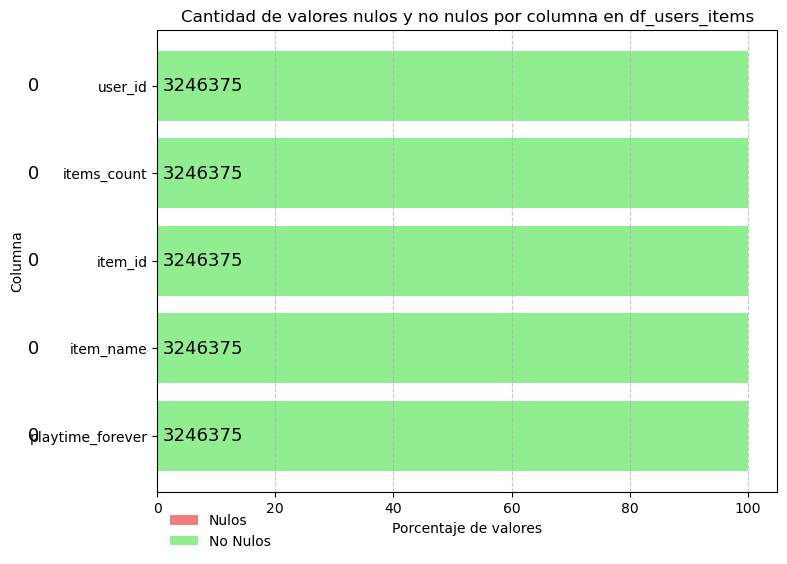

In [22]:
data_type_check_EDA(df_users_items)

#### **📤 LOAD**
Guardamos los cambios y exportamos df_items_users parquet

In [23]:
#Guardamos los cambios en parquet
table = pa.Table.from_pandas(df_users_items)
ruta_parquet = os.path.join('..', '0 Dataset', '1.2_users_items_LISTO.parquet')
df_users_items.to_parquet(ruta_parquet)
print(f'Se guardó el archivo {ruta_parquet}')

Se guardó el archivo ..\0 Dataset\1.2_users_items_LISTO.parquet


Desarrollamos la funcion

In [24]:
     #pendiente

Probamos la funcion

In [25]:
     #pendiente     

___


## 4🌐`best_developer_year(año : int*)`:

___



### Usuario con más horas jugadas para el género dado y acumulación de horas jugadas por año de lanzamiento.

Ejemplo de retorno: 
`
{"Usuario con más horas jugadas para Género X" : us213ndjss09sdf,
			     "Horas jugadas":[{Año: 2013, Horas: 203}, {Año: 2012, Horas: 100}, {Año: 2011, Horas: 23}]}`


___